# 0717 CPLD Data Pre Processing
Se encarga de utilizar los datos de bitflips en la CPLD
En particular se utiliza un kernel tipo [0,1,1] para solo identificar casos en donde el error se solventa y el sub sistema se reinicia.

El output de interes seran solo estos bitnP que se evaluan esta tarea.

Se desarrollaron otras cosas como
- edge up vs edge down approach

In [1]:
import glob
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from lib.cpld import parse_message, count_fails, read_cpld_data

In [2]:
df, df_bad = read_cpld_data('../0_raw/Campaign3/cpld/run/cpld_data_*.dat', debug=True)

  Registros válidos: 1081111
  Registros inválidos: 40769


In [3]:
print(df.head())

                        time  lfsrTMR    B0    B1   B2
0 2022-11-09 11:52:17.613816        0  FF00  FF00  NaN
1 2022-11-09 11:52:18.022465        0  FF00  FF00  NaN
2 2022-11-09 11:52:18.835929        0  FF00  FF00  NaN
3 2022-11-09 11:52:19.240983        0  FF00  FF00  NaN
4 2022-11-09 11:52:19.648855        0  FF00  FF00  NaN


In [ ]:
df[df["B0"] != "FF00"]

,time,lfsrTMR,B0,B1,B2
20163,2022-11-09 14:22:13.492523,0,FF04,FF00,NaN
20164,2022-11-09 14:22:13.916571,0,FF04,FF00,NaN
20165,2022-11-09 14:22:14.337584,0,FF04,FF00,NaN
20166,2022-11-09 14:22:14.761574,0,FF04,FF00,NaN
20167,2022-11-09 14:22:15.182561,0,FF04,FF00,NaN
...,...,...,...,...,...
882828,2022-11-15 11:30:59.466592,0,FF29,F700,NaN
882829,2022-11-15 11:30:59.890450,0,FF39,F700,NaN
882830,2022-11-15 11:31:00.310967,0,FF39,F700,NaN
882831,2022-11-15 11:31:00.778862,0,FF29,F700,NaN


In [5]:
# filtrado a solo datos donde podemos medir TMR
df = df[df["lfsrTMR"]==0]
print(df.shape)

(1051683, 5)


In [6]:
from lib.cpld import cpld_pipeline

In [7]:
import time
import numpy as np
import re


def cpld_pipeline(df, debug=False):
    # Patrón para 4 dígitos hexadecimales
    hex_pat = re.compile(r'^[0-9A-Fa-f]{4}$')
    valid_mask = ( # Filtrar el DataFrame original
        df['B0'].astype(str).str.fullmatch(hex_pat.pattern) &
        df['B1'].astype(str).str.fullmatch(hex_pat.pattern)
    )
    df_valid = df[valid_mask].reset_index(drop=True)

    # --- Medidor de tiempo total ---
    t_start = time.perf_counter()

    # ------------------------------------ Información inicial
    n_samples = len(df_valid)

    # Convertir columnas hex a uint16 a manera de tener el valor de los bits cambiados
    t1 = time.perf_counter()
    b0_int = df_valid['B0'].apply(lambda s: int(s, 16)).to_numpy(dtype=np.uint16)
    b1_int = df_valid['B1'].apply(lambda s: int(s, 16)).to_numpy(dtype=np.uint16)
    if debug:
        print(f"[0] Número total de muestras: {n_samples}")
        print(f"[1] Conversión hex→uint16: {time.perf_counter() - t1:.2f}s")

    # Aplicar máscara y extraer byte alto
    t2 = time.perf_counter()
    masked0 = ((~b0_int) & 0xFF00) >> 8
    masked1 = ((~b1_int) & 0xFF00) >> 8

    if debug: print(f"[2] Enmascarado de bytes altos: {time.perf_counter() - t2:.2f}s")
    

    t_start = time.perf_counter()

    # ---------------Desplegar bits: matriz (n_muestras × 8) para cada byte
    t3 = time.perf_counter()

    masked0_uint8 = masked0.astype(np.uint8)          # shape: (N,)
    masked1_uint8 = masked1.astype(np.uint8)          # shape: (N,)
    # expandir dimensión para que unpackbits opere por fila
    masked0_2d = masked0_uint8[:, np.newaxis]         # shape: (N,1)
    masked1_2d = masked1_uint8[:, np.newaxis]         # shape: (N,1)

    # desempacar bits little-endian a lo largo de cada fila → (N,8)
    bits0 = np.unpackbits(masked0_2d, axis=1, bitorder='little')  # shape: (N,8)
    bits1 = np.unpackbits(masked1_2d, axis=1, bitorder='little')  # shape: (N,8)

    if debug: print(f"[3] Unpack de bits por byte: {time.perf_counter() - t3:.2f}s")

    # 4. Concatenar para obtener (n_muestras × 16)
    t4 = time.perf_counter()
    bits = np.hstack([bits0, bits1]).astype(bool) 
    if debug: 
        print(f"[4] Concatenación de bits0+b1: {time.perf_counter() - t4:.2f}s")
        print(bits.shape)  

    # 5. Conteo instantáneo de fallas (popcount)
    t5 = time.perf_counter()
    fails_inst = bits.sum(axis=1)
    if debug:
        print(f"[5] Conteo instantáneo de fallas: {time.perf_counter() - t5:.2f}s")
        print(fails_inst.shape)

    # 6. Detección de resets para bias
    t6 = time.perf_counter()
    resets = (fails_inst == 0) & (np.concatenate([[False], fails_inst[:-1] > 0]))
    reset_indices = np.nonzero(resets)[0]
    if debug: print(f"[6] Detección de resets ({len(reset_indices)} encontrados): {time.perf_counter() - t6:.2f}s")

    # 7. Cálculo de acumulado ajustado
    t7 = time.perf_counter()
    cumsum = fails_inst.cumsum()
    bias_array = np.zeros_like(cumsum)
    for idx in reset_indices:
        bias_array[idx:] += cumsum[idx - 1]
    fails_acum = np.maximum.accumulate(cumsum + bias_array)
    if debug: print(f"[7] Cálculo de acumulado ajustado: {time.perf_counter() - t7:.2f}s")

    # 8. Conteo de flancos de subida (edges) y acumulado por bit
        # --> se obtiene bit_counts
    t8 = time.perf_counter()
    prev = np.vstack([np.zeros((1, 16), bool), bits[:-1]])
    edges = bits & (~prev)
    bit_counts = edges.cumsum(axis=0)
    if debug: print(f"[8] Conteo de flancos de subida por bit: {time.perf_counter() - t8:.2f}s")



    # 9. Detección de errores periódicos por bit
    t9 = time.perf_counter()

    # ---------- 1) Transiciones por bit ---------------------------
    bits_int = bits.astype(np.int8)           # 0 / 1
    # diff con padding 0 al inicio y al final para capturar flancos finales
    trans   = np.diff(bits_int, axis=0, prepend=0, append=0)   # shape (N+1,16)

    edges_up = (trans == +1)[:-1]   # volvemos a (N,16)
    edges_dn = (trans == -1)[:-1]

    # ---------- 2) Contadores acumulados --------------------------
    rising_cumsum   = edges_up.cumsum(axis=0)      # episodios que empezaron
    falling_cumsum  = edges_dn.cumsum(axis=0)      # episodios que terminaron
    
    bit_periodic = falling_cumsum   # cantidad de episodios cerrados corresponden a aquellos periodos terminados

    # ----
    if debug:
        print(f"[9] Detección de errores periódicos: {time.perf_counter() - t9:.2f}s")
        print(bit_periodic.shape)


    # --- Asignar resultados de vuelta a df_valid ---
    t10 = time.perf_counter()
    df_valid['fails_inst'] = fails_inst
    df_valid['fails_acum'] = fails_acum
    for k in range(16):
        df_valid[f'bitn{k}']  = bit_counts[:, k]
        df_valid[f'bitnP{k}'] = bit_periodic[:, k]
    if debug:
        print(f"[10] Escritura en DataFrame: {time.perf_counter() - t10:.2f}s")
        # --- Tiempo total ---
        print(f"Tiempo total aproximado: {time.perf_counter() - t_start:.2f}s")

    # Testing
    import numpy.testing as npt
    npt.assert_array_less(bit_periodic, bit_counts + 1, 
        err_msg="bitnP debería ser ≤ bitn para cada bit y muestra")

    return df_valid, (edges, resets) ,(edges_up, edges_dn), bit_periodic



In [8]:
df_valid, (edges, resets) ,(edges_up, edges_dn), bit_periodic = cpld_pipeline(df, debug=False)

array([False, False, False, ..., False, False, False], shape=(1051601,))

In [31]:
df_resets = pd.DataFrame({
    "time": df_valid.time, "resets": resets
})

reset_times = df_resets[df_resets["resets"].values].time


In [34]:
reset_times_diff = reset_times.diff()

In [43]:
dir(reset_times_diff)

['T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__column_consortium_standard__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__

In [42]:
pd.to_datetime(reset_times_diff)

TypeError: dtype timedelta64[ns] cannot be converted to datetime64[ns]

In [39]:
reset_times_diff.values[1:]

array([ 557801204000, 2379047654000,    6327260000, ...,   11394992000,
       1518562290000, 2891530565000],
      shape=(27560,), dtype='timedelta64[ns]')

In [10]:
bit_periodic

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [4519, 6843, 6795, ..., 3105, 6249, 5156],
       [4519, 6843, 6795, ..., 3105, 6249, 5156],
       [4519, 6843, 6795, ..., 3105, 6249, 5156]], shape=(1051601, 16))

In [11]:
edges_up.sum(axis=1).cumsum(axis=0)

array([    0,     0,     0, ..., 95860, 95860, 95860], shape=(1051601,))

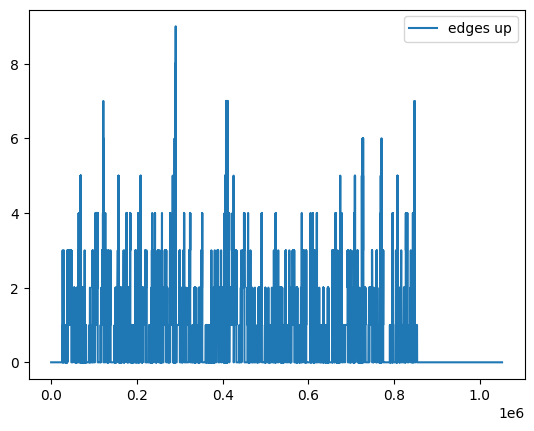

In [12]:
plt.plot(edges_up.sum(axis=1).cumsum(axis=0) - edges_dn.sum(axis=1).cumsum(axis=0), label="edges up")
#plt.plot(, label="edges down")
#plt.plot(resets.cumsum(), label="resets")
plt.legend()
plt.show()

In [13]:
resets

array([False, False, False, ..., False, False, False], shape=(1051601,))

In [14]:
edges_dn[26704]

array([False,  True, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False])

In [15]:
np.where(edges_dn)

(array([ 26704,  26704,  26704, ..., 847712, 847712, 853323],
       shape=(95860,)),
 array([ 1,  5, 13, ...,  8, 10, 11], shape=(95860,)))

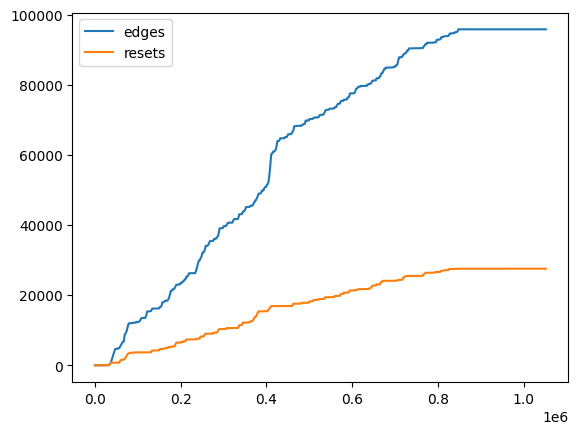

In [16]:
plt.plot(edges.sum(axis=1).cumsum(), label="edges")
plt.plot(resets.cumsum(), label="resets")
plt.legend()
plt.show()

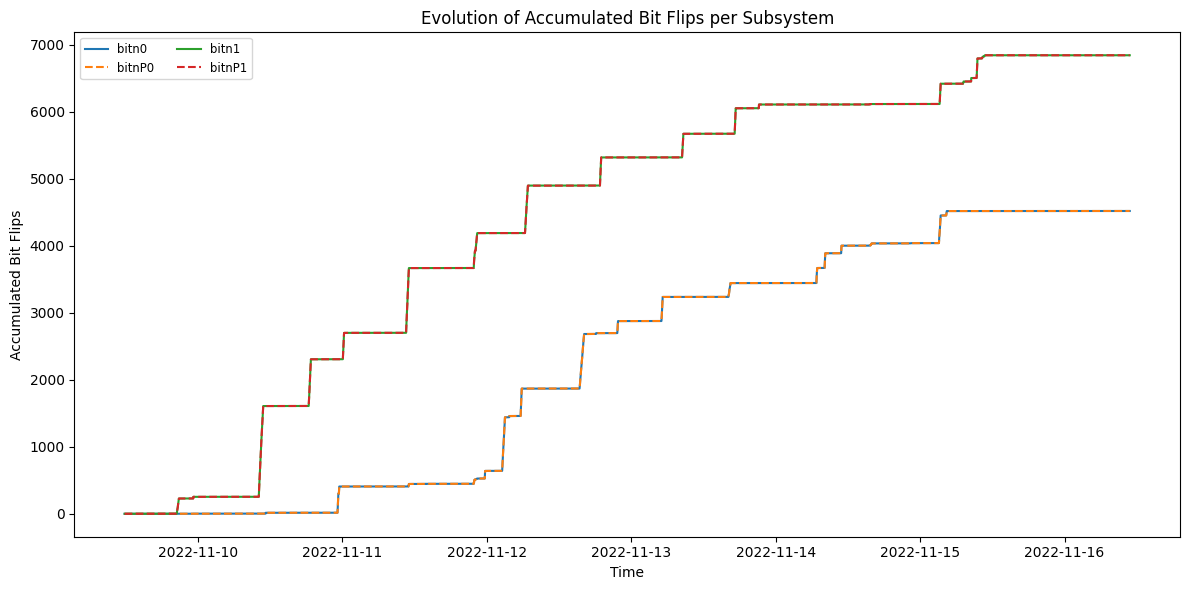

In [17]:
import matplotlib.pyplot as plt


# Assume df is the DataFrame already loaded with a datetime 'Time' column
# and bitn0..bitn15 and bitnP0..bitnP15 columns.

# Identify the bit columns
bit_columns = [col for col in df_valid.columns if col.startswith('bitn')]

bit_columns = ["bitn0", "bitnP0","bitn1", "bitnP1"]
line_styles = ['-', '--', '-', '--']

# Set Time as index for plotting
df_plot = df_valid.set_index('time')[bit_columns]

# Plot all bit error counts over time
plt.figure(figsize=(12, 6))
for idx, col in enumerate(bit_columns):
    plt.plot(df_plot.index, df_plot[col], line_styles[idx], label=col)

plt.xlabel('Time')
plt.ylabel('Accumulated Bit Flips')
plt.title('Evolution of Accumulated Bit Flips per Subsystem')
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [18]:
import numpy as np

# bits: array bool (N,16)   ---->  True = bit en error
N, NB = bits.shape
assert NB == 16

# ---------- 1) Transiciones por bit ---------------------------
bits_int = bits.astype(np.int8)           # 0 / 1
# diff con padding 0 al inicio y al final para capturar flancos finales
trans   = np.diff(bits_int, axis=0, prepend=0, append=0)   # shape (N+1,16)

edges_up = (trans == +1)[:-1]   # volvemos a (N,16)
edges_dn = (trans == -1)[:-1]

# ---------- 2) Contadores acumulados --------------------------
rising_cumsum   = edges_up.cumsum(axis=0)      # episodios que empezaron
falling_cumsum  = edges_dn.cumsum(axis=0)      # episodios que terminaron

bitn  = rising_cumsum                          # igual que edges.cumsum anterior
bitnP = rising_cumsum - (rising_cumsum - falling_cumsum)   # = falling_cumsum

# ---------- 3) Verificación de coherencia ---------------------
# bitnP nunca debe exceder bitn
assert np.all(bitnP <= bitn), "Inconsistencia: bitnP > bitn"

# ---------- 4) Exportar a DataFrame (opcional) ----------------
for k in range(16):
    df_valid[f'bitn{k}']  = bitn[:, k]
    df_valid[f'bitnP{k}'] = bitnP[:, k]


#" Diferencia "
plt.figure()
for k in range(3):
    plt.plot((bitn - bitnP)[:, k].astype(int).cumsum(axis=0), label=f'bit{k}')

plt.xlabel('Índice de muestra')
plt.ylabel('Edge (0→1)')
plt.legend()
plt.title('Edges - Patrones periódicos — bits 0,1,2')
plt.tight_layout()
plt.show()


NameError: name 'bits' is not defined

In [ ]:
df_valid.to_csv('../1_data/campaign3_cpld.csv')

Analizar el tema de Binning usando el tiempo de reset:
- medir el tiempo de reset
- considerar el binning como multiplo de este timepo
- hacer un Maximum Likelyhood con modelo de Poisson de manera de maximizar mi observacion dada en el bin, osea N
    - esto se hace para mnimizar el bias que estoy observando
- para N pequeño considerar que existe un error asimetrico, esto es considerado on ROOT